Diplomado en ciencia de datos

Módulo 6                                  

Proyecto 1

Andrea Morales González

In [ ]:
import numpy as np
np.random.seed(4)
import pandas as pd


In [1]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


El siguiente dataset contiene el registro histórico del comportamiento de las accciones de Google entre junio de 2016 y junio de 2021.

In [ ]:
dataset= pd.read_csv('/content/drive/MyDrive/Proyecto1/GOOG.csv')
dataset['date']= pd.to_datetime(dataset['date'])
dataset['date']= pd.to_datetime(dataset['date'].dt.date)
dataset= dataset.set_index('date')
dataset= dataset.sort_index()
dataset.head(10)

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,,
2016-06-14,GOOG,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
2016-06-15,GOOG,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2016-06-16,GOOG,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
2016-06-17,GOOG,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
2016-06-20,GOOG,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0
2016-06-21,GOOG,695.94,702.77,692.0100,698.40,1465634,695.94,702.77,692.0100,698.40,1465634,0.0,1.0
2016-06-22,GOOG,697.46,700.86,693.0819,699.06,1184318,697.46,700.86,693.0819,699.06,1184318,0.0,1.0
2016-06-23,GOOG,701.87,701.95,687.0000,697.45,2171415,701.87,701.95,687.0000,697.45,2171415,0.0,1.0
2016-06-24,GOOG,675.22,689.40,673.4500,675.17,4449022,675.22,689.40,673.4500,675.17,4449022,0.0,1.0


En este proyecto haremos la predicción utilizando unicamente el valor más alto (high) de la acción.

In [ ]:
dataset1= dataset[['high']]
dataset1

,high
date,
2016-06-14,722.470
2016-06-15,722.980
2016-06-16,716.650
2016-06-17,708.820
2016-06-20,702.480
...,...
2021-06-07,2468.000
2021-06-08,2494.495
2021-06-09,2505.000


<Axes: xlabel='date'>

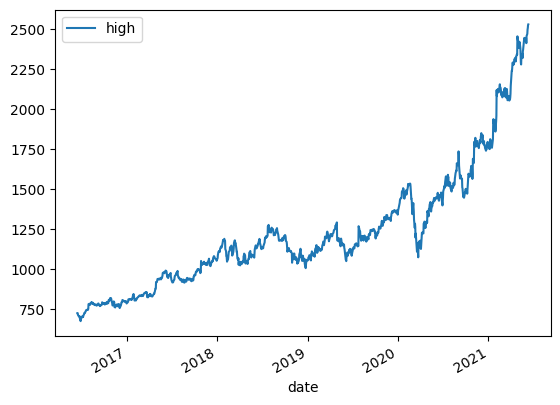

In [ ]:
import matplotlib.pyplot as plt
dataset1.plot()

In [ ]:
dataset1.loc['2021-01-01':].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111 entries, 2021-01-04 to 2021-06-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    111 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


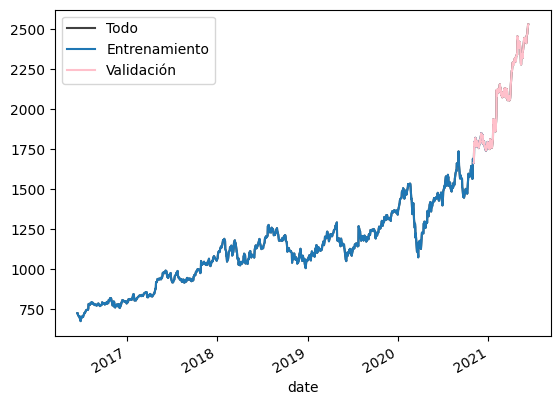

In [ ]:
#Para el entrenamiento utilizaremos los valores que están entre junio de 2016 y diciembre de 2020
set_entremaniento = dataset1.loc['2016-06-13':'2020-12-31']
# Para la validación y predicción utilizaremos el año 2021
set_validacion = dataset1.loc['2020-11-01':]

ax=dataset1.plot(color='0.25')
ax=set_entremaniento.plot(ax=ax,label='Entrenamiento')
ax=set_validacion.plot(ax=ax,color='pink', label='Validación')
#ax=set_predi.plot(ax=ax,color='purple', label='Validación')
_=ax.legend(labels=['Todo','Entrenamiento','Validación'])

Normalizamos los valores de la acción para garantizar que se encuentren en un rango definido y sea posible utilizar LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range= (0,1))
set_entremaniento_escalado= sc.fit_transform(set_entremaniento)

Entrenamiento

Para realizar estás predicciones utilizaremnos la estrategia de predicción de series temporales basada en ventanas deslizantes (One-step ahead forecasting with sliding window).

Se utiliza esta estretegia porque es sencilla y efectiva, además permite ajustar la longitud de memoria (time_step) según el problema.

In [ ]:
#Se entrena al modelo para que, dados los últimos 60 valores se prediga el siguiente valor inmediato
time_step=60
X_train= []
Y_train= []
m= len(set_entremaniento_escalado)

for i in range(time_step,m):
  X_train.append(set_entremaniento_escalado[i-time_step:i,0])
  Y_train.append(set_entremaniento_escalado[i,0])
X_train, Y_train= np.array(X_train), np.array(Y_train)
X_train= np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

dim_entrada = (X_train.shape[1],1)
dim_salida= 1
na=50 #numero de neuronas

modelo= Sequential()
modelo.add(LSTM(units=na,input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop',loss='mse')
modelo.fit(X_train, Y_train, epochs=100,batch_size=32)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0191
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0023
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0016
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0011
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0011
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 9.2723e-04
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.5357e-04
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.7646e-04
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.0788e-04
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.8939e-04
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━

Prueba

In [ ]:
x_test= set_validacion.values
x_test= sc.transform(x_test)

X_test = []
for i in range (time_step, len(x_test)):
  X_test.append(x_test[i-time_step:i,0])

X_test= np.array(X_test)
X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

prediccion= modelo.predict(X_test)
prediccion= sc.inverse_transform(prediccion)

prediccion = pd.Series(prediccion.flatten(), index=set_validacion.index[time_step:])


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


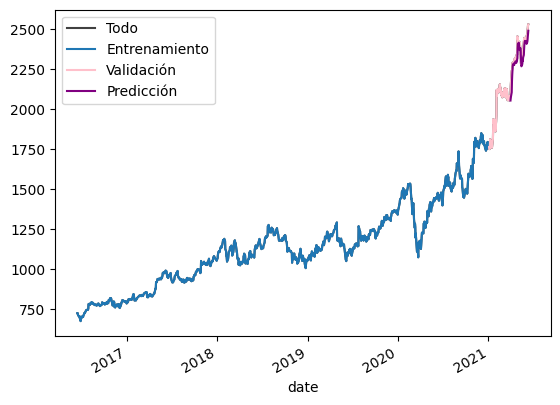

In [ ]:
ax=dataset1.plot(color='0.25')
ax=set_entremaniento.plot(ax=ax,label='Entrenamiento')
ax=set_validacion.plot(ax=ax,color='pink', label='Validación')
ax=prediccion.plot(ax=ax,color='purple', label='Predicción')
_=ax.legend(labels=['Todo','Entrenamiento','Validación', 'Predicción'])

La forma general de la curva predicha sigue de cerca la del valor real, lo cual indica que el modelo ha aprendido correctamente la tendencia y el comportamiento general de los datos. Sin embargo, hay ligeras diferencias en la precisión punto por punto, especialmente en ciertos picos o caídas abruptas, donde el modelo suaviza los cambios. Esto es común en modelos RNN, ya que tienden a generar predicciones más “suaves” que los datos reales, especialmente si hay ruido o alta variabilidad.


Justificación

Se utiliza el modelo LSTM ya que Introduce celdas de memoria y puertas (entrada, olvido y salida) que permiten regular el flujo de información y conservar de manera más efectiva la información relevante a lo largo de la secuencia. Además se utiliza el optimizador 'rmsprop' para ajustar los parámetros de la red de manera eficiente, acelerando la convergencia hacia un mínimo local o global de la función de pérdida y ayuda a estabilizar el entrenamiento y garantizar que la red sea capaz de aprender patrones a largo plazo sin perder precisión lo que es importante para la estrategia utilizada.